301호 강의실

In [1]:
import pandas as pd
import csv
import matplotlib.pyplot as plt
import numpy as np

In [43]:
df = pd.read_csv('301.csv', encoding='cp949')

In [44]:
#전처리과정
df = df.rename(columns={'field1':'temperature'})
df = df.rename(columns={'field2':'humidity'})
df = df.rename(columns={'field3':'co2'})
df = df.rename(columns={'field4':'pm1'})
df = df.rename(columns={'field5':'pm2.5'})
df = df.rename(columns={'field6':'pm10'})
df = df.drop('entry_id', axis=1)
df = df.iloc[:, :7]

In [17]:
df.head()

,created_at,temperature,humidity,co2,pm1,pm2.5,pm10
0,2019-05-13 13:05:27 UTC,22,45,290,40,48,50
1,2019-05-13 13:06:47 UTC,23,44,250,41,49,50
2,2019-05-13 13:08:07 UTC,23,43,224,39,49,50
3,2019-05-13 13:09:27 UTC,23,44,204,74,48,491
4,2019-05-13 13:10:48 UTC,23,44,191,41,49,62


In [45]:
df = df.replace("-", np.nan)
df = df.dropna(axis=0)
df.iloc[:,1:] = df.iloc[:,1:].astype(str).astype(float)

In [46]:
for i in range(1, len(df)):
    if (df.iloc[i,4]>df.iloc[i-1,4]+20) or (df.iloc[i, 4] > 200):
        df.iloc[i, 4]=df.iloc[i-1, 4]
    if (df.iloc[i,5]>df.iloc[i-1,5]+20) or (df.iloc[i, 5] > 200):
        df.iloc[i, 5]=df.iloc[i-1, 5]
    if (df.iloc[i,6]>df.iloc[i-1,6]+20) or (df.iloc[i, 6] > 200):
        df.iloc[i, 6]=df.iloc[i-1, 6]

In [47]:
df['created_at'] = pd.to_datetime(df['created_at'])
df = df.set_index('created_at', inplace=False)

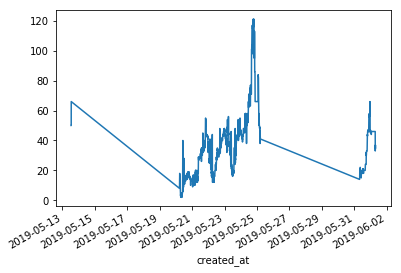

In [48]:
df['pm10'].plot()

In [49]:
#중간에 수집을 못한 날들 빼고.. 수집 잘 된 날만 가져옴

df = df.loc['2019-05-21' : '2019-05-24 14']

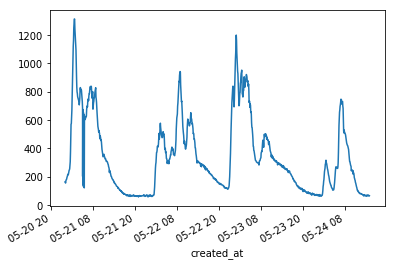

In [76]:
df['co2'].plot()

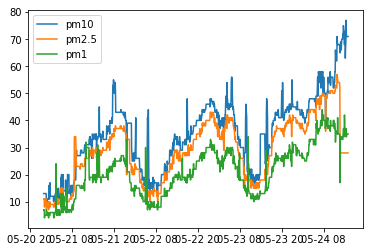

In [75]:
plt.plot(df['pm10'], label='pm10')
plt.plot(df['pm2.5'], label='pm2.5')
plt.plot(df['pm1'], label='pm1')
plt.legend(loc='upper left')
plt.show()

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1114 entries, 2019-05-21 00:03:04 to 2019-05-24 14:59:45
Data columns (total 6 columns):
temperature    1114 non-null float64
humidity       1114 non-null float64
co2            1114 non-null float64
pm1            1114 non-null float64
pm2.5          1114 non-null float64
pm10           1114 non-null float64
dtypes: float64(6)
memory usage: 60.9 KB


In [35]:
train = df.iloc[:1110, 5]
test = df.iloc[1110:,5]

In [36]:
from pmdarima.arima import auto_arima

In [39]:
stepwise_fit = auto_arima(train, start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                          start_P=0, seasonal=False, d=1, D=1, trace=True,
                          error_action='ignore',  # don't want to know if an order does not work
                          suppress_warnings=True,  # don't want convergence warnings
                          stepwise=True)  # set to stepwise
stepwise_fit.fit(train)
stepwise_fit.summary()

Fit ARIMA: order=(1, 1, 1); AIC=6123.885, BIC=6143.929, Fit time=0.195 seconds
Fit ARIMA: order=(0, 1, 0); AIC=6195.912, BIC=6205.935, Fit time=0.004 seconds
Fit ARIMA: order=(1, 1, 0); AIC=6190.299, BIC=6205.332, Fit time=0.020 seconds
Fit ARIMA: order=(0, 1, 1); AIC=6187.453, BIC=6202.486, Fit time=0.015 seconds
Fit ARIMA: order=(2, 1, 1); AIC=6123.571, BIC=6148.627, Fit time=0.252 seconds
Fit ARIMA: order=(2, 1, 0); AIC=6171.618, BIC=6191.663, Fit time=0.029 seconds
Fit ARIMA: order=(2, 1, 2); AIC=6124.214, BIC=6154.281, Fit time=0.372 seconds
Fit ARIMA: order=(3, 1, 2); AIC=6125.924, BIC=6161.002, Fit time=0.510 seconds
Fit ARIMA: order=(3, 1, 1); AIC=6125.089, BIC=6155.156, Fit time=0.310 seconds
Total fit time: 1.708 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                 1109
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -3056.786
Method:                       css-mle   S.D. of innovations              3.808
Date:                Sat, 01 Jun 2019   AIC                           6123.571
Time:                        16:41:41   BIC                           6148.627
Sample:                             1   HQIC                          6133.046
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0512      0.037      1.369      0.171      -0.022       0.124
ar.L1.D.y      0.7559      0.038     19.829      0.000       0.681       0.831
ar.L2.D.y     -0.0494      0.032     -1.523      0.128      -0.113       0.014
ma.L1.D.y     -0.9047      0.024    -37.348      0.000      -0.952      -0.857
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.4628           +0.0000j            1.4628            0.0000
AR.2           13.8290           +0.0000j           13.8290            0.0000
MA.1            1.1054           +0.0000j            1.1054            0.0000
-----------------------------------------------------------------------------
"""

In [40]:
from statsmodels.tsa.arima_model import ARIMA

In [42]:
model = ARIMA(train, order=(2,1,1))
model_fit = model.fit(trend='c',full_output=True, disp=False)
print(model_fit.summary())

C:\Users\HanSung\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\HanSung\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.pm10   No. Observations:                 1109
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -3056.786
Method:                       css-mle   S.D. of innovations              3.808
Date:                Sat, 01 Jun 2019   AIC                           6123.571
Time:                        16:42:02   BIC                           6148.627
Sample:                             1   HQIC                          6133.046
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0512      0.037      1.369      0.171      -0.022       0.124
ar.L1.D.pm10     0.7559      0.038     19.829      0.000       0.681       0.831
ar.L2.D.pm10    -0.0494      0.032     -1.52

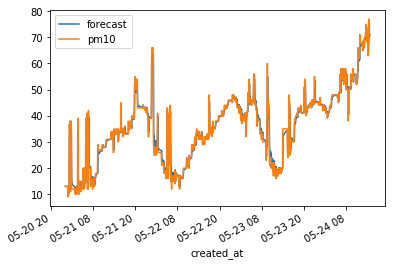

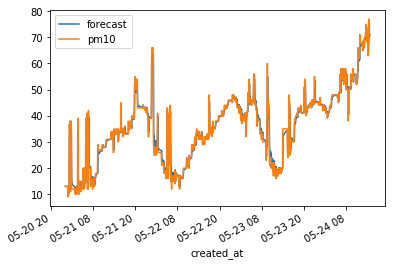

In [77]:
model_fit.plot_predict()

In [122]:
forecast = model_fit.forecast(steps=4)
fore = forecast[0]

In [79]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [82]:
rmse = sqrt(mean_squared_error(test, fore))
print('Test RMSE : %.3f' %rmse)
n = train.shape[0]
d = np.abs(np.diff(train)).sum()/(n-1)
err = np.abs(test - fore)
mase = err.mean()/d
print('Test MASE : %.3f' %mase)

Test RMSE : 0.028
Test MASE : 0.015


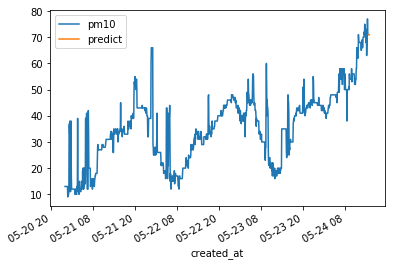

In [123]:
train = pd.DataFrame(train)
fore = pd.DataFrame(fore)
test = pd.DataFrame(test)
fore.columns = ["predict"]
fore = fore.set_index(test.index)
pd.concat([train, fore], axis=1).plot()

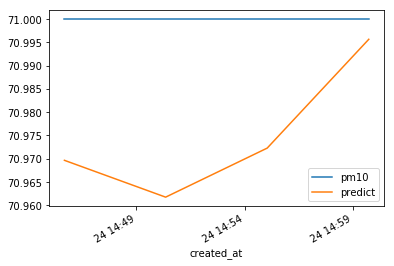

In [127]:
pd.concat([test, fore], axis=1).plot()